# IMPORTS AND DATASET CLASSES

In [1]:
import os
import glob
import pickle
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import binary_dilation, binary_erosion
from skimage.transform import resize
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras_unet_collection import models
from tensorflow import keras
from keras_unet_collection.utils import dummy_loader
import cv2
import gc

import os
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import binary_dilation, binary_erosion
from skimage.transform import resize

import os
from PIL import Image

import sys
sys.path.append('cloth3d')
sys.path.append('cloth3d/DataReader')
sys.path.append('cloth3d/DataReader/smpl')

from cloth3d.DataReader.read import DataReader
from cloth3d.DataReader.depth_render import Render
from cloth3d.DataReader.util import intrinsic, extrinsic

# Path to data
SRC = 'cloth3d++_subset/'
print('SRC:', SRC)

N_TRAIN = 128
N_VAL = 16

      
class DataGenerator_Together(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data_list, root, batch_size=16, shuffle=True, data_augmentation=False):
        super().__init__()
        'Initialization'
        self.data_list = data_list
        self.root = root
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        # data augmentation configuration
        self.augmenter = None
        if data_augmentation:
            self.augmenter = ImageDataGenerator(
                rotation_range=20,
                width_shift_range=0.1,
                height_shift_range=0.1,
                zoom_range=0.2,
                horizontal_flip=True,
                vertical_flip=True,
            )

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.data_list) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Find list of IDs
        data_list_temp = self.getdatalist(index)

        # Generate data
        X, y = self.__data_generation(data_list_temp)
        
        return X, y

    def getdatalist(self, index):
        'Get the list of data for one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        data_list_batch = [self.data_list[k] for k in indexes]

        return data_list_batch

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.data_list))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)


    def __data_generation(self, data_list):
      'Generates data containing batch_size samples'
      X_img, Y = [], []
      for f in data_list:
        # Load depth image
        dpt = np.load(open(self.root + f[:5] + '/depth/'+f+'.npy', 'rb'))
        mask = dpt>0
        # Normalize depth image
        #min = dpt[mask].min()
        #mean = dpt[mask].mean()
        #max = dpt[mask].max()
        #dpt[mask] = (dpt[mask] - min + 0.001) / 2.0
        dpt[dpt>0] -= dpt[dpt>0].mean()
        dpt[dpt<0] = 0

        # Read RGB image
        img = cv2.imread(self.root + f[:5] + '/image/'+f+'.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)#.astype(np.float32)
        img = np.array(img)

        nml = cv2.imread(self.root + f[:5] + '/normals/'+f+'.jpg')
        nml = np.array(nml)
        
        # Normalize RGB image
        r_mean, g_mean, b_mean = [img[:, :, 0][mask].mean(), img[:, :, 1][mask].mean(), img[:, :, 2][mask].mean()]
        r_std, g_std, b_std = [img[:, :, 0][mask].std(), img[:, :, 1][mask].std(), img[:, :, 2][mask].std()]
        img[:, :, 0][mask] = (img[:, :, 0][mask] - r_mean) / (r_std + 0.0001)
        img[:, :, 1][mask] = (img[:, :, 1][mask] - g_mean) / (g_std + 0.0001)
        img[:, :, 2][mask] = (img[:, :, 2][mask] - b_mean) / (b_std + 0.0001)

        
        nml[:, :, 0][~mask] = 0.
        nml[:, :, 1][~mask] = 0.
        nml[:, :, 2][~mask] = 0.
        r_min, g_min, b_min = [nml[:, :, 0][mask].min(), nml[:, :, 1][mask].min(), nml[:, :, 2][mask].min()]
        r_max, g_max, b_max = [nml[:, :, 0][mask].max(), nml[:, :, 1][mask].max(), nml[:, :, 2][mask].max()]
        nml[:, :, 0][mask] = (nml[:, :, 0][mask] - r_min) / (r_max - r_min + 0.0001)
        nml[:, :, 1][mask] = (nml[:, :, 1][mask] - g_min) / (g_max - g_min + 0.0001)
        nml[:, :, 2][mask] = (nml[:, :, 2][mask] - b_min) / (b_max - b_min + 0.0001)

        # r_mean, g_mean, b_mean = [nml[:, :, 0][mask].mean(), nml[:, :, 1][mask].mean(), nml[:, :, 2][mask].mean()]
        # r_std, g_std, b_std = [nml[:, :, 0][mask].std(), nml[:, :, 1][mask].std(), nml[:, :, 2][mask].std()]
        # nml[:, :, 0][mask] = (nml[:, :, 0][mask] - r_mean) / (r_std + 0.0001)
        # nml[:, :, 1][mask] = (nml[:, :, 1][mask] - g_mean) / (g_std + 0.0001)
        # nml[:, :, 2][mask] = (nml[:, :, 2][mask] - b_mean) / (b_std + 0.0001)
       
        
        X_img.append(img)
        Y.append(np.concatenate((dpt[..., np.newaxis], nml), axis=-1))

      # img = preprocess(img)

      # Augment the data
      if self.augmenter is not None:
          augmented_images = []
          augmented_y = []
          for img, target in zip(X_img, Y):

              # Modified version
              augmented = self.augmenter.random_transform(np.concatenate((img, target), axis=-1))
              augmented_images.append(augmented[:, :, :3])  # RGB channels
              augmented_y.append(augmented[:, :, 3:])  # Normal channels

          X_img = augmented_images
          Y = augmented_y
          return np.array(X_img), np.array(Y)

      else:
          return np.array(X_img), np.array(Y)



SRC: cloth3d++_subset/


# MODELS

In [2]:
# Create model
# model_together = models.unet_2d((256, 256, 3), [64, 128, 256, 512, 1024], n_labels=4,
#                       stack_num_down=2, stack_num_up=1,
#                       activation='GELU', output_activation='Sigmoid', 
#                       batch_norm=True, pool='max', unpool=False, name='unet')
# model_normals= models.unet_2d((256, 256, 3), [64, 128, 256, 512, 1024], n_labels=3,
#                       stack_num_down=2, stack_num_up=1,
#                       activation='GELU', output_activation='Sigmoid', 
#                       batch_norm=True, pool='max', unpool=False, name='unet')
# model_depth = models.unet_2d((256, 256, 6), [64, 128, 256, 512, 1024], n_labels=1,
#                       stack_num_down=2, stack_num_up=1,
#                       activation='GELU', output_activation='Sigmoid', 
#                       batch_norm=True, pool='max', unpool=False, name='unet')

In [3]:
model_together = models.transunet_2d((256, 256, 3), [64, 128, 256, 512, 1024], n_labels=4,
                            stack_num_down=2, stack_num_up=1,
                            activation='GELU', output_activation='Sigmoid',
                            batch_norm=True, pool='max', unpool=False, name='transunet_2d', embed_dim=100, num_heads=4)

# DATA LISTS

In [4]:
######################################################
######################################################
########### DATA FOR TESTING THE NOTEBOOK ############
######################################################
######################################################

SRC = 'cloth3d++_subset'
subfolders = [x for x in os.listdir(SRC) if x.isdigit()]
subfolders.sort(key=int)
print(subfolders)

training_folders = subfolders
validation_folders = subfolders
test_folders = subfolders

train_list = []
for sample in training_folders:
    try:
        train_list += os.listdir(SRC + sample + '/image')
    except:
        pass
train_list = list(map(lambda filename: filename[:-4], train_list))[0::80]

validation_list = []
for sample in validation_folders:
    try:
        validation_list += os.listdir(SRC + sample + '/image')
    except:
        pass
validation_list = list(map(lambda filename: filename[:-4], validation_list))[0::80]

test_list = []
for sample in test_folders:
    try:
        test_list += os.listdir(SRC + sample + '/image')
    except:
        pass
test_list = list(map(lambda filename: filename[:-4], test_list))[0::80]

['00001', '00002', '00003', '00004', '00005', '00006', '00007', '00008', '00009', '00011', '00012', '00014', '00015', '00016', '00017', '00018', '00019', '00020', '00021', '00023', '00024', '00027', '00028', '00029', '00030', '00031', '00033', '00034', '00035', '00036', '00037', '00038', '00039', '00040', '00041', '00043', '00044', '00045', '00046', '00048', '00049', '00050', '00051', '00053', '00054', '00056', '00057', '00058', '00059', '00060', '00061', '00062', '00063', '00064', '00065', '00066', '00067', '00068', '00069', '00070', '00071', '00072', '00073', '00074', '00076', '00077', '00081', '00082', '00083', '00084', '00085', '00086', '00087', '00088', '00089', '00090', '00091', '00092', '00093', '00096', '00097', '00098', '00100', '00101', '00102', '00103', '00105', '00106', '00107', '00108', '00110', '00112', '00113', '00114', '00115', '00116', '00117', '00118', '00120', '00121', '00122', '00124', '00125', '00127', '00128', '00129', '00130', '00131', '00132', '00133', '00134', 

In [5]:
# Read the data lists
SRC = 'cloth3d++_subset/'
subfolders = [x for x in os.listdir(SRC) if x.isdigit()]
subfolders.sort(key=int)
print(subfolders)

training_folders = subfolders[:N_TRAIN]
validation_folders = subfolders[N_TRAIN:N_TRAIN+N_VAL]
test_folders = subfolders[N_TRAIN+N_VAL:]

train_list = []
for sample in training_folders:
    try:
        train_list += os.listdir(SRC + sample + '/image')
    except:
        pass
train_list = list(map(lambda filename: filename[:-4], train_list))
to_remove = [261, 259, 188]

for x in to_remove:
    del train_list[x]

validation_list = []
for sample in validation_folders:
    try:
        validation_list += os.listdir(SRC + sample + '/image')
    except:
        pass
validation_list = list(map(lambda filename: filename[:-4], validation_list))

test_list = []
for sample in test_folders:
    try:
        test_list += os.listdir(SRC + sample + '/image')
    except:
        pass
test_list = list(map(lambda filename: filename[:-4], test_list))

['00001', '00002', '00003', '00004', '00005', '00006', '00007', '00008', '00009', '00011', '00012', '00014', '00015', '00016', '00017', '00018', '00019', '00020', '00021', '00023', '00024', '00027', '00028', '00029', '00030', '00031', '00033', '00034', '00035', '00036', '00037', '00038', '00039', '00040', '00041', '00043', '00044', '00045', '00046', '00048', '00049', '00050', '00051', '00053', '00054', '00056', '00057', '00058', '00059', '00060', '00061', '00062', '00063', '00064', '00065', '00066', '00067', '00068', '00069', '00070', '00071', '00072', '00073', '00074', '00076', '00077', '00081', '00082', '00083', '00084', '00085', '00086', '00087', '00088', '00089', '00090', '00091', '00092', '00093', '00096', '00097', '00098', '00100', '00101', '00102', '00103', '00105', '00106', '00107', '00108', '00110', '00112', '00113', '00114', '00115', '00116', '00117', '00118', '00120', '00121', '00122', '00124', '00125', '00127', '00128', '00129', '00130', '00131', '00132', '00133', '00134', 

In [6]:
print(len(train_list))
print(len(validation_list))
print(len(test_list))

29964
3213
2305


In [7]:
class WarmUpCosineDecayScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_learning_rate, target_learning_rate, total_steps, warmup_steps):
        super(WarmUpCosineDecayScheduler, self).__init__()
        self.initial_learning_rate = initial_learning_rate
        self.target_learning_rate = target_learning_rate
        self.total_steps = total_steps
        self.warmup_steps = warmup_steps
        self.decay_steps = total_steps - warmup_steps

    def __call__(self, step):
        # Convert to float32 to ensure the operations are compatible
        step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        decay_steps = tf.cast(self.decay_steps, tf.float32)

        # Compute the warmup learning rate
        warmup_lr = self.initial_learning_rate + (self.target_learning_rate - self.initial_learning_rate) * (step / warmup_steps)

        # Compute the cosine decay learning rate
        cosine_decay = 0.5 * (1 + tf.cos(np.pi * (step - warmup_steps) / decay_steps))
        decayed_lr = (self.target_learning_rate - self.initial_learning_rate) * cosine_decay + self.initial_learning_rate

        # Choose the learning rate based on the step
        learning_rate = tf.where(step < warmup_steps, warmup_lr, decayed_lr)
        return learning_rate

    def get_config(self):
        return {
            'initial_learning_rate': self.initial_learning_rate,
            'target_learning_rate': self.target_learning_rate,
            'total_steps': self.total_steps,
            'warmup_steps': self.warmup_steps
        }

In [8]:
def visualize_hist(history, show=True, filename=None, title='Training history'):
    train_hist = history.history

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
    fig.suptitle(title, fontsize=14, fontweight='bold')

    ax1.plot(train_hist['loss'])
    ax1.plot(train_hist['val_loss'])
    ax1.set(xlabel='epoch', ylabel='Loss')
    ax1.legend(['train', 'valid'], loc='upper right')

    ax2.plot(train_hist['mae'])
    ax2.plot(train_hist['val_mae'])
    ax2.set(xlabel='epoch', ylabel='MAE')
    ax2.legend(['train', 'valid'], loc='upper right')

    if show:
        plt.show()

    if filename is not None:
        fig.savefig(filename)

# TRAIN ALL-TOGETHER MODEL

Number of data used to train:
29964

Epoch 1/12
14982/14982 [==============================] - 2524s 168ms/step - loss: 0.0381 - mae: 0.1417 - val_loss: 0.0019 - val_mae: 0.0173
Epoch 2/12
14982/14982 [==============================] - 2587s 173ms/step - loss: 9.2457e-04 - mae: 0.0078 - val_loss: 0.0019 - val_mae: 0.0085
Epoch 3/12
14982/14982 [==============================] - 2573s 172ms/step - loss: 7.4612e-04 - mae: 0.0049 - val_loss: 0.0015 - val_mae: 0.0066
Epoch 4/12
14982/14982 [==============================] - 2668s 178ms/step - loss: 6.1828e-04 - mae: 0.0043 - val_loss: 0.0013 - val_mae: 0.0060
Epoch 5/12
14982/14982 [==============================] - 2625s 175ms/step - loss: 5.2759e-04 - mae: 0.0039 - val_loss: 0.0014 - val_mae: 0.0059
Epoch 6/12
14982/14982 [==============================] - 2558s 171ms/step - loss: 4.6117e-04 - mae: 0.0036 - val_loss: 0.0012 - val_mae: 0.0057
Epoch 7/12
14982/14982 [==============================] - 2575s 172ms/step - loss: 4.0750e-04 - m

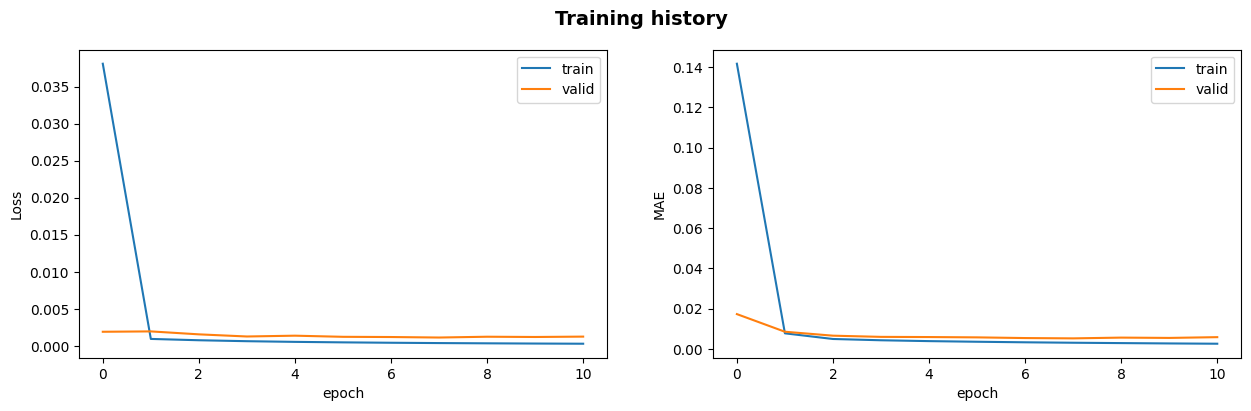

In [9]:
# Hiperparámetros
initial_learning_rate = 1e-7
target_learning_rate = 1e-4
batch_size = 2
n_epochs = 12
checkpoint = './best_model_AT_norm.keras'
shuffle = True
verbose = 1
wu_ratio = 0.1

# Creación de generadores de datos para cargar los datos
train_together = DataGenerator_Together(train_list, SRC, batch_size=batch_size, shuffle=shuffle, data_augmentation=True)
validation_together = DataGenerator_Together(validation_list, SRC, batch_size=batch_size, shuffle=False)

print('Number of data used to train:')
print(len(train_together.data_list))
print('')

total_steps = len(train_together.data_list) * n_epochs
warmup_steps = int(wu_ratio * total_steps)

experiment_name = f'lr_decay_{initial_learning_rate}_{target_learning_rate}_wu_ratio_{wu_ratio}_unet_normals_bs_{batch_size}'

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=os.path.join('./logs_normals_norm', experiment_name))

# Creación del scheduler de tasa de aprendizaje
lr_schedule = WarmUpCosineDecayScheduler(
    initial_learning_rate=initial_learning_rate,
    target_learning_rate=target_learning_rate,
    total_steps=total_steps,
    warmup_steps=warmup_steps
)

# Definición del optimizador
model_together.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), 
                       loss=tf.keras.losses.MeanSquaredError(), 
                       metrics=['mae'])

es = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=3)

# Guardado del mejor modelo basado en val_mae
mc = tf.keras.callbacks.ModelCheckpoint(checkpoint, monitor='val_mae', mode='min', save_best_only=True)

# Entrenamiento del modelo y guardado del historial
history_together = model_together.fit(train_together, 
                                      validation_data=validation_together, 
                                      epochs=n_epochs, 
                                      verbose=verbose, 
                                      callbacks=[mc, es, tensorboard_callback])

# Crear directorio para guardar los resultados si no existe
if not os.path.exists(experiment_name):
    os.makedirs(experiment_name)

# Visualizar y guardar el historial de entrenamiento
filename = os.path.join(experiment_name, 'train_history.jpg')
visualize_hist(history_together, show=True, filename=filename)

# Guardar el historial de entrenamiento en un archivo pickle
with open(os.path.join(experiment_name, 'train_history.pkl'), 'wb') as handle:
    pickle.dump(history_together.history, handle, protocol=pickle.HIGHEST_PROTOCOL)
#with open('train_history.pkl', 'wb') as handle:
 #   pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)    

In [10]:
import tensorflow as tf
from keras_unet_collection.layer_utils import GELU # Importa todas las capas necesarias
from keras_unet_collection.transformer_layers import patch_extract, patch_embedding

# Define la ruta a tu modelo guardado

checkpoint = './best_model_AT_norm.keras'

# Carga el modelo utilizando custom_objects para registrar todas las capas personalizadas
model2 = tf.keras.models.load_model(checkpoint, custom_objects={
    'GELU': GELU,
    'patch_extract': patch_extract,
    'patch_embedding': patch_embedding,
    'WarmUpCosineDecayScheduler': WarmUpCosineDecayScheduler,
    # Agrega aquí otras capas personalizadas si es necesario
})

# Muestra el resumen del modelo
model2.summary()

Model: "transunet_2d_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 transunet_2d_down0_0 (Conv2D)  (None, 256, 256, 64  1728        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 transunet_2d_down0_0_bn (Batch  (None, 256, 256, 64  256        ['transunet_2d_down0_0[0][0]']   
 Normalization)                 )                                                

In [21]:
# Evaluate the trained model on the test set
 
test_together = DataGenerator_Together(test_list, SRC, batch_size=1, shuffle=False)

# model.load_weights(checkpoint)

print('Evaluating on the test set')

_mae = 0
for step in range(test_together.__len__()):
  # Load the batch
  X, Y = test_together.__getitem__(step)
  
  # validate on one batch
  prediction = model2.predict(tf.convert_to_tensor(X, dtype=tf.float32), verbose=0)
  
  # Note that in the evaluation the background is ignored
  # Therefore the MAE on the test set is not comparable with the train/validation
  _mae += np.abs(prediction[Y[:,:,:,0]!=0] - Y[Y[:,:,:,0]!=0]).mean()
  _mae_depth = np.abs(prediction[Y[:,:,:,0]!=0][:,0] - Y[Y[:,:,:,0]!=0][:,0]).mean()


  # Some house keeping
  gc.collect()
  tf.keras.backend.clear_session()

print("The total mean absolute error is {}\n".format(_mae/(step+1)))
print("The depth mean absolute error is {}\n".format(_mae_depth/(step+1)))

Evaluating on the test set
The total mean absolute error is 0.02301939899413988

The depth mean absolute error is 3.639416772175183e-05



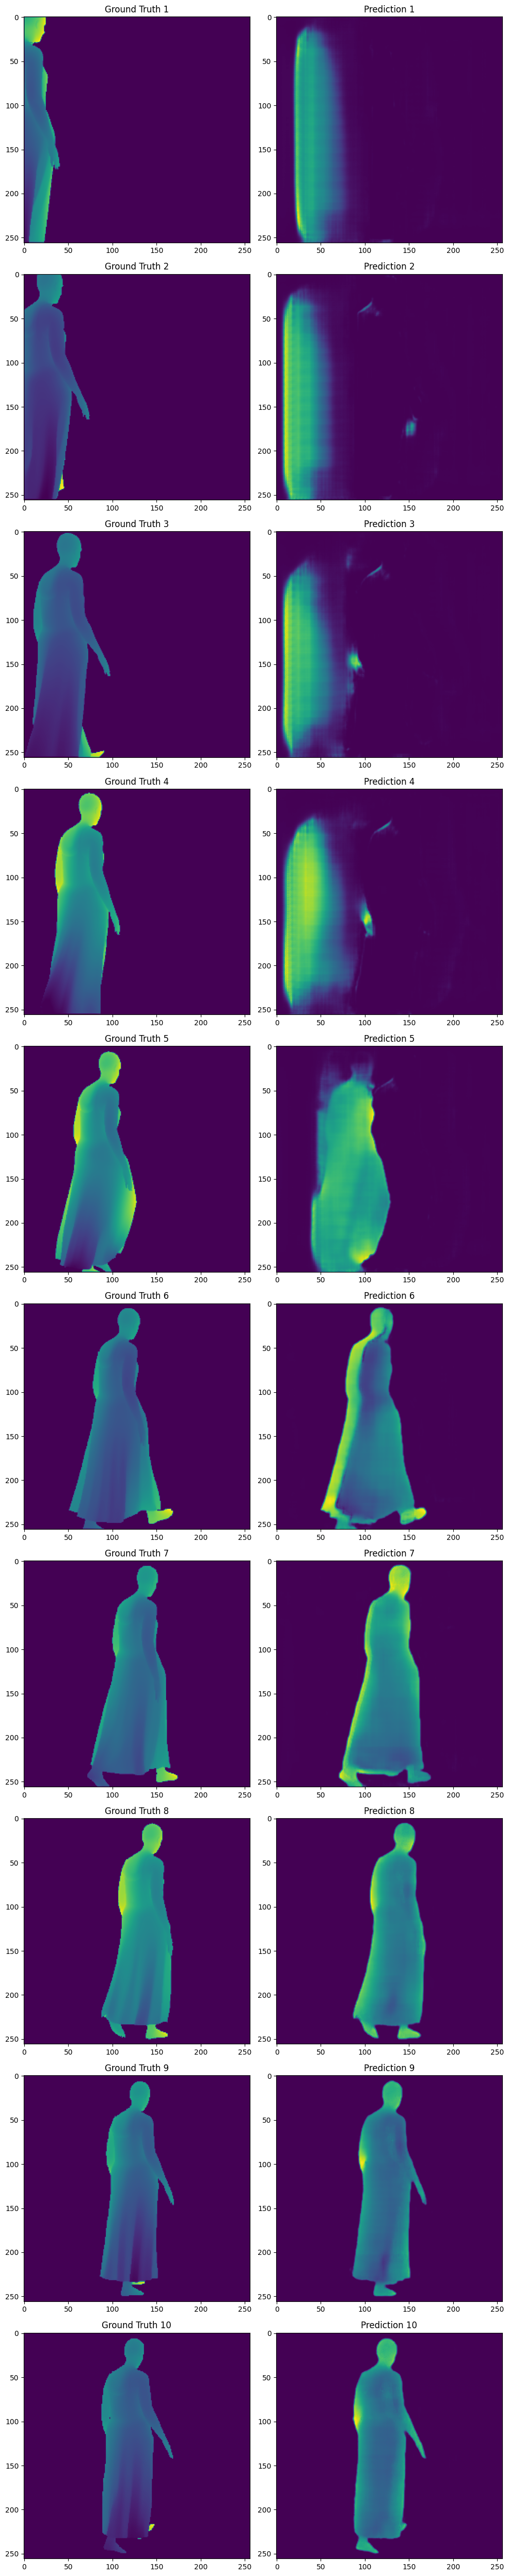

In [18]:
# Number of images to plot
num_images = 10
batch_size = 10

# Create subplots
fig, axes = plt.subplots(num_images, 2, figsize=(10, 5 * num_images))

for i in range(num_images):
    # Get a different index for each image
    X, Y = test_together.__getitem__(i)

    # Make prediction
    predictions = model2.predict(tf.convert_to_tensor(X, dtype=tf.float32), verbose=0)
    
    # Plot ground truth
    axes[i, 0].imshow(Y[0, :, :, 0])
    axes[i, 0].set_title(f'Ground Truth {i+1}')
    
    # Plot prediction
    axes[i, 1].imshow(predictions[0, :, :, 0])
    axes[i, 1].set_title(f'Prediction {i+1}')

# Display the subplots
plt.tight_layout()
plt.show()

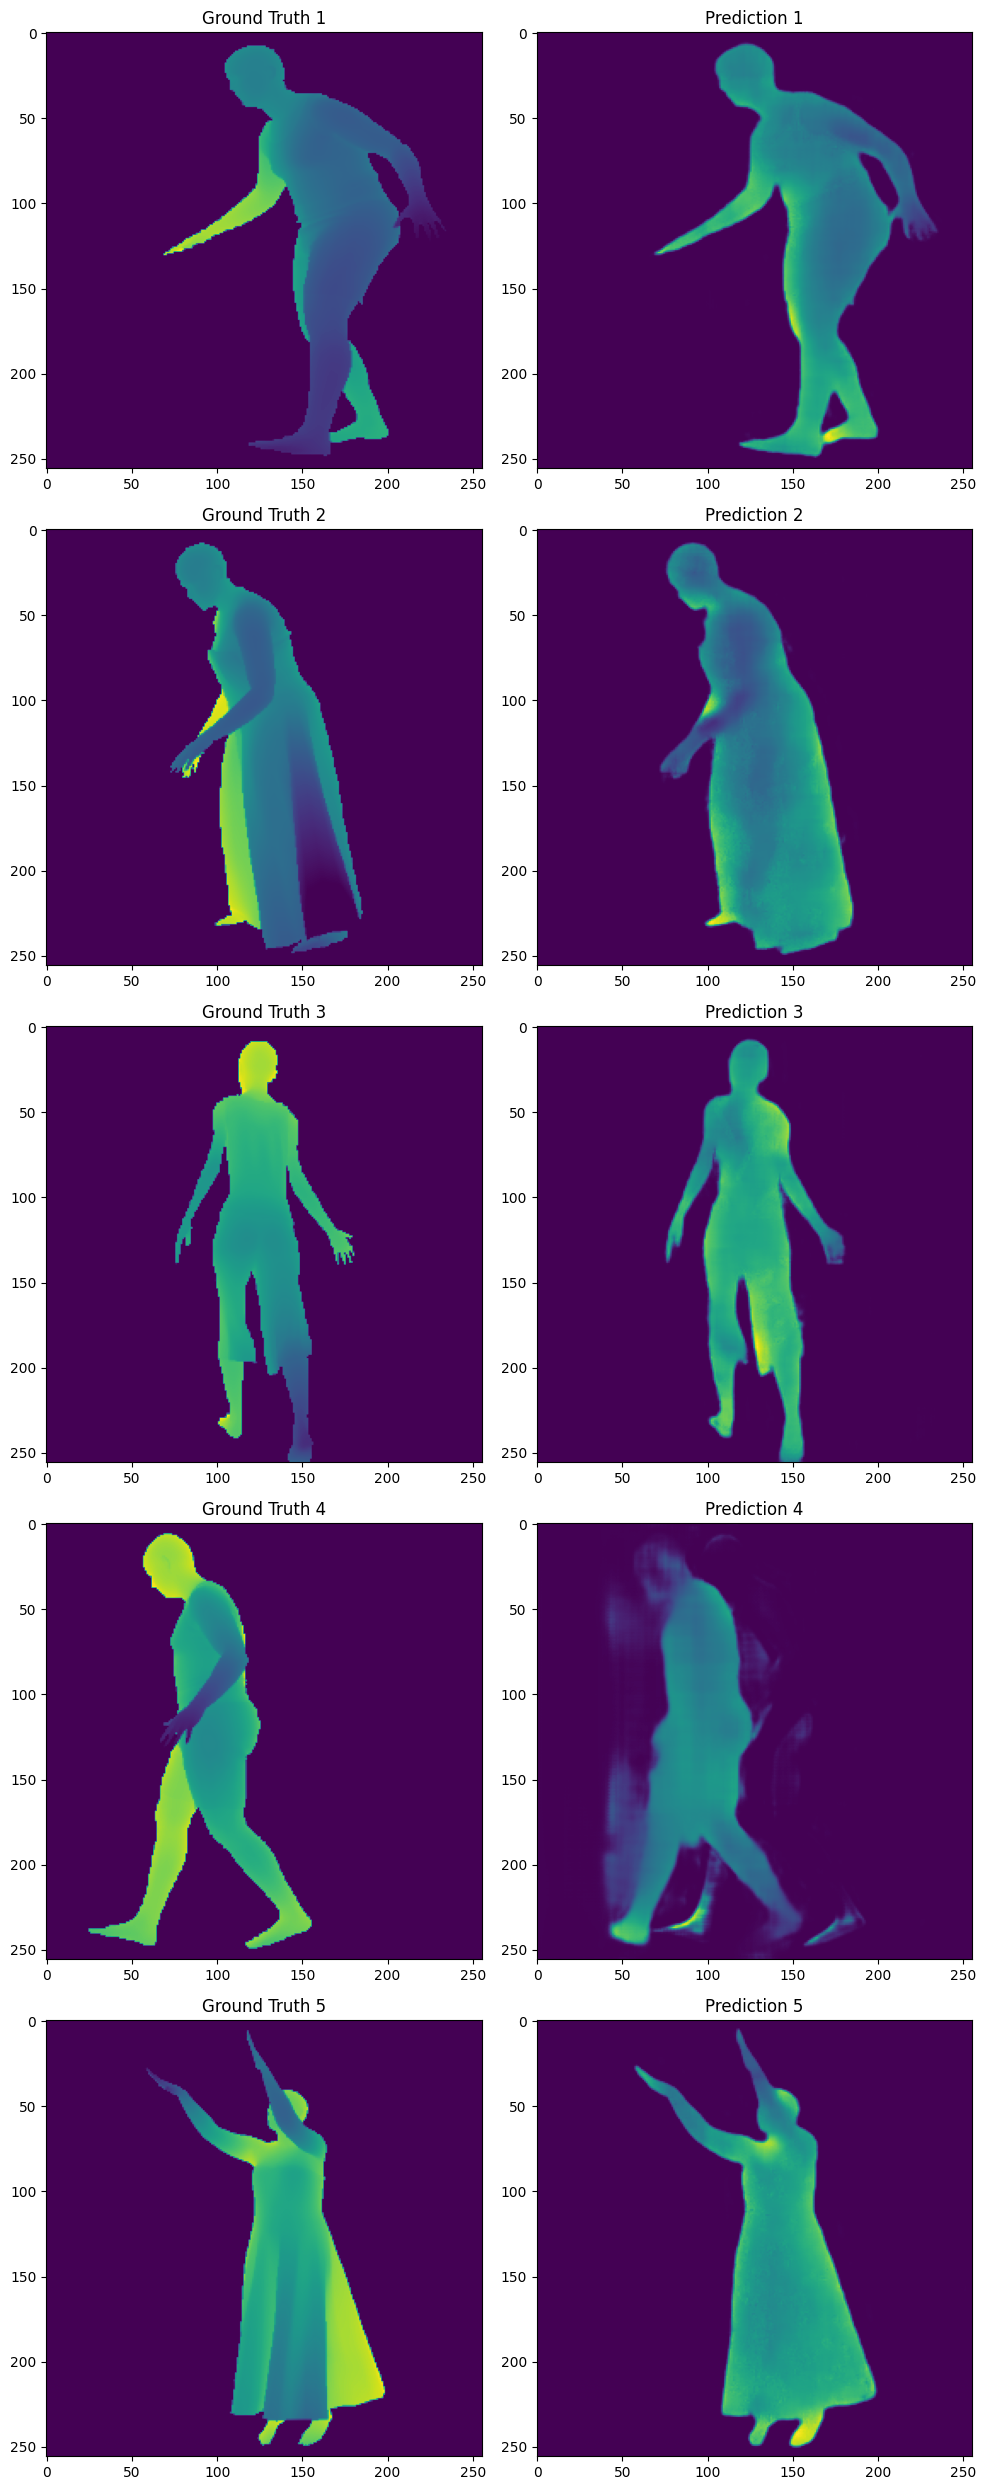

In [19]:
# Number of images to plot
num_images = 5
batch_size = 10

# Create subplots
fig, axes = plt.subplots(num_images, 2, figsize=(10, 5 * num_images))

for i in range(num_images):
    # Get a different random index in the test set
    X, Y = test_together.__getitem__(np.random.randint(0, test_together.__len__()))

    # Make prediction
    predictions = model2.predict(tf.convert_to_tensor(X, dtype=tf.float32), verbose=0)
    
    # Plot ground truth
    axes[i, 0].imshow(Y[0, :, :, 0])
    axes[i, 0].set_title(f'Ground Truth {i+1}')
    
    # Plot prediction
    axes[i, 1].imshow(predictions[0, :, :, 0])
    axes[i, 1].set_title(f'Prediction {i+1}')

# Display the subplots
plt.tight_layout()
plt.show()


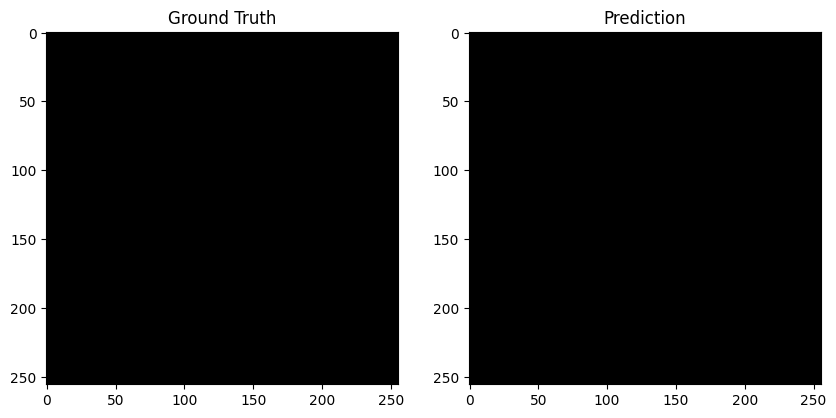

In [24]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot ground truth
axes[0].imshow(Y[0,:,:,1:])
axes[0].set_title('Ground Truth')

# Plot prediction
axes[1].imshow(prediction[0,:,:,1:])
axes[1].set_title('Prediction')

# Display the subplots
plt.show()

In [25]:
# Visualization
train_hist = history_together.history

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Training history', fontsize=14, fontweight='bold')

ax1.plot(train_hist['loss'])
ax1.plot(train_hist['val_loss'])
ax1.set(xlabel='epoch', ylabel='Loss')
ax1.legend(['train', 'valid'], loc='upper right')

ax2.plot(train_hist['mae'])
ax2.plot(train_hist['val_mae'])
ax2.set(xlabel='epoch', ylabel='MAE')
ax2.legend(['train', 'valid'], loc='upper right')

NameError: name 'history_together' is not defined

# TRAIN SEQUENTIAL MODEL

In [13]:
# hyperparameters
lr = 1e-3
batch_size = 4
n_epochs = 2
checkpoint = './best_model_N.keras'
shuffle = True
verbose = 1

# Training

# creating data generators to load the data
train_normals = DataGenerator_Normals(train_list, SRC, batch_size=batch_size, shuffle=shuffle, data_augmentation=True)
validation_normals = DataGenerator_Normals(validation_list, SRC, batch_size=batch_size, shuffle=False)
print('Number of data used to train:')
print(len(train_normals.data_list))
print('')

# defining the optimizer
model_normals.compile(tf.keras.optimizers.Adam(learning_rate=lr), loss=tf.keras.losses.MeanSquaredError(), metrics=['mae'])

es = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=3)

# saving the best model based on val_loss
mc = tf.keras.callbacks.ModelCheckpoint(checkpoint, monitor='val_mae', mode='min', save_best_only=True, save_freq=5)

# training the model and saving the history
history_normals = model_normals.fit(train_normals, validation_data=validation_normals, epochs=n_epochs, verbose=verbose, callbacks=[mc, es])

#with open('train_history.pkl', 'wb') as handle:
 #   pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

Number of data used to train:
4

Epoch 1/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step - loss: 1219.0698 - mae: 7.4983 - val_loss: 1764.4043 - val_mae: 7.5463
Epoch 2/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 1214.7500 - mae: 7.4030 - val_loss: 1763.3656 - val_mae: 7.5923


In [14]:
# Evaluate the trained model on the test set

test_normals = DataGenerator_Normals(test_list, SRC, batch_size=1, shuffle=False)

# model.load_weights(checkpoint)

print('Evaluating on the test set')

_mae = 0
for step in range(test_normals.__len__()):
  # Load the batch
  X, Y = test_normals.__getitem__(step)
  
  # validate on one batch
  prediction = model_normals.predict(tf.convert_to_tensor(X, dtype=tf.float32), verbose=0)
  
  # Note that in the evaluation the background is ignored
  # Therefore the MAE on the test set is not comparable with the train/validation
  #_mae += np.abs(prediction[:,:,Y[:, :, 0][0]!=0] - Y[:,:,Y[:, :, 0][0]!=0]).mean()
  #_mae_depth = np.abs(prediction[:,:,Y[:, :, 0][0]!=0] - Y[:,:,Y[:, :, 0][0]!=0]).mean()
  _mae += np.abs(prediction - Y).mean()


  # Some house keeping
  gc.collect()
  tf.keras.backend.clear_session()

print("The normals mean absolute error is {0:.3f}\n".format(_mae/(step+1)))

Evaluating on the test set
The normals mean absolute error is 7.592



In [15]:
# Load the batch
step = 0
test_normals = DataGenerator_Normals(test_list, SRC, batch_size=1, shuffle=False)
X, Y = test_normals.__getitem__(step)

# Validate on one batch
prediction = model_normals.predict(tf.convert_to_tensor(X, dtype=tf.float32), verbose=0)

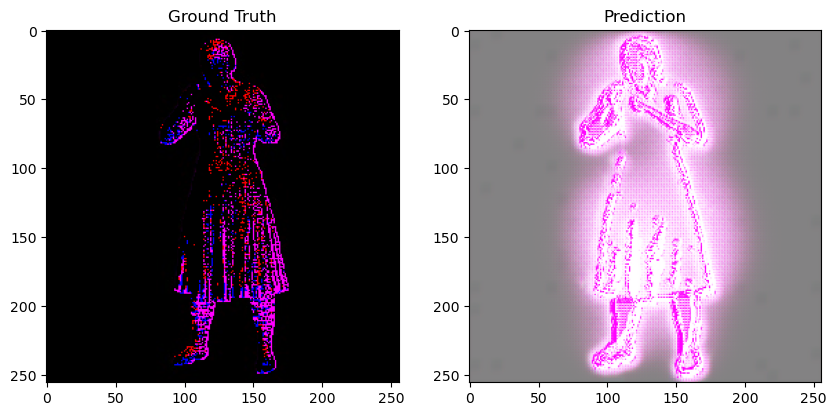

In [16]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot ground truth
axes[0].imshow(Y[0])
axes[0].set_title('Ground Truth')

# Plot prediction
axes[1].imshow(prediction[0])
axes[1].set_title('Prediction')

# Display the subplots
plt.show()

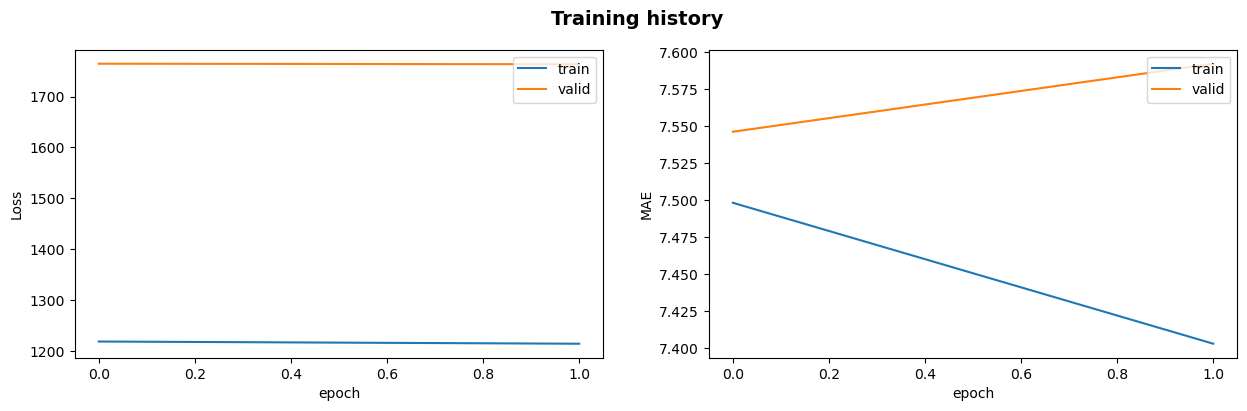

In [17]:
# Visualization
train_hist = history_normals.history

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Training history', fontsize=14, fontweight='bold')

ax1.plot(train_hist['loss'])
ax1.plot(train_hist['val_loss'])
ax1.set(xlabel='epoch', ylabel='Loss')
ax1.legend(['train', 'valid'], loc='upper right')

ax2.plot(train_hist['mae'])
ax2.plot(train_hist['val_mae'])
ax2.set(xlabel='epoch', ylabel='MAE')
ax2.legend(['train', 'valid'], loc='upper right')

In [18]:
# hyperparameters
lr = 1e-3
batch_size = 4
n_epochs = 2
checkpoint = './best_model_S.keras'
shuffle = True
verbose = 1

# Training

# creating data generators to load the data
train_depth = DataGenerator_Depth(train_list, SRC, model_normals, batch_size=batch_size, shuffle=shuffle, data_augmentation=True)
validation_depth = DataGenerator_Depth(validation_list, SRC, model_normals, batch_size=batch_size, shuffle=False)
print('Number of data used to train:')
print(len(train_normals.data_list))
print('')

# defining the optimizer
model_depth.compile(tf.keras.optimizers.Adam(learning_rate=lr), loss=tf.keras.losses.MeanSquaredError(), metrics=['mae'])

es = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=3)

# saving the best model based on val_loss
mc = tf.keras.callbacks.ModelCheckpoint(checkpoint, monitor='val_mae', mode='min', save_best_only=True, save_freq=5)

# training the model and saving the history
history_depth = model_depth.fit(train_depth, validation_data=validation_depth, epochs=n_epochs, verbose=verbose, callbacks=[mc, es])

#with open('train_history.pkl', 'wb') as handle:
 #   pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

Number of data used to train:
4

Epoch 1/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step - loss: 0.2017 - mae: 0.4244 - val_loss: 0.3085 - val_mae: 0.5310
Epoch 2/2
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - loss: 0.1397 - mae: 0.3333 - val_loss: 0.5187 - val_mae: 0.6846


In [19]:
# Evaluate the trained model on the test set

test_depth = DataGenerator_Depth(test_list, SRC, model_normals, batch_size=1, shuffle=False)

# model.load_weights(checkpoint)

print('Evaluating on the test set')

_mae = 0
for step in range(test_depth.__len__()):
  # Load the batch
  X, Y = test_depth.__getitem__(step)
  
  # validate on one batch
  prediction = model_depth.predict(tf.convert_to_tensor(X, dtype=tf.float32), verbose=0)
  
  # Note that in the evaluation the background is ignored
  # Therefore the MAE on the test set is not comparable with the train/validation
  #_mae += np.abs(prediction[:,:,Y[:, :, 0][0]!=0] - Y[:,:,Y[:, :, 0][0]!=0]).mean()
  #_mae_depth = np.abs(prediction[:,:,Y[:, :, 0][0]!=0] - Y[:,:,Y[:, :, 0][0]!=0]).mean()
  _mae += np.abs(prediction[Y!=0] - Y[Y!=0]).mean()


  # Some house keeping
  gc.collect()
  tf.keras.backend.clear_session()

print("The depth mean absolute error is {0:.3f}\n".format(_mae/(step+1)))

Evaluating on the test set
The depth mean absolute error is 0.551



In [20]:
# Load the batch
step = 0
test_depth = DataGenerator_Depth(test_list, SRC, model_normals, batch_size=1, shuffle=False)
X, Y = test_depth.__getitem__(step)

# Validate on one batch
prediction = model_depth.predict(tf.convert_to_tensor(X, dtype=tf.float32), verbose=0)

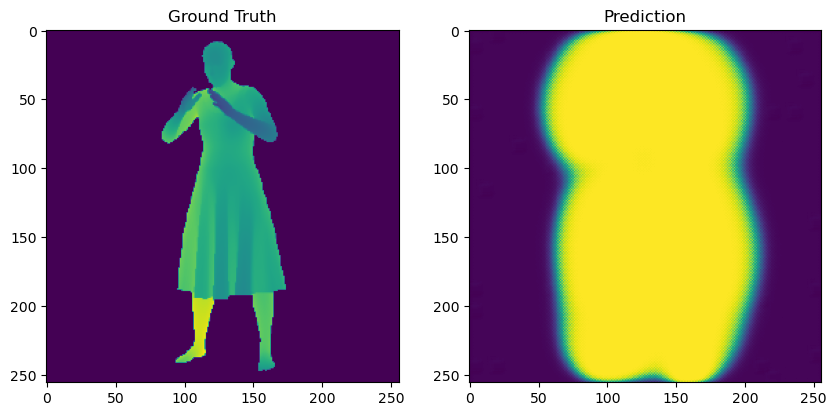

In [21]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot ground truth
axes[0].imshow(Y[0])
axes[0].set_title('Ground Truth')

# Plot prediction
axes[1].imshow(prediction[0])
axes[1].set_title('Prediction')

# Display the subplots
plt.show()

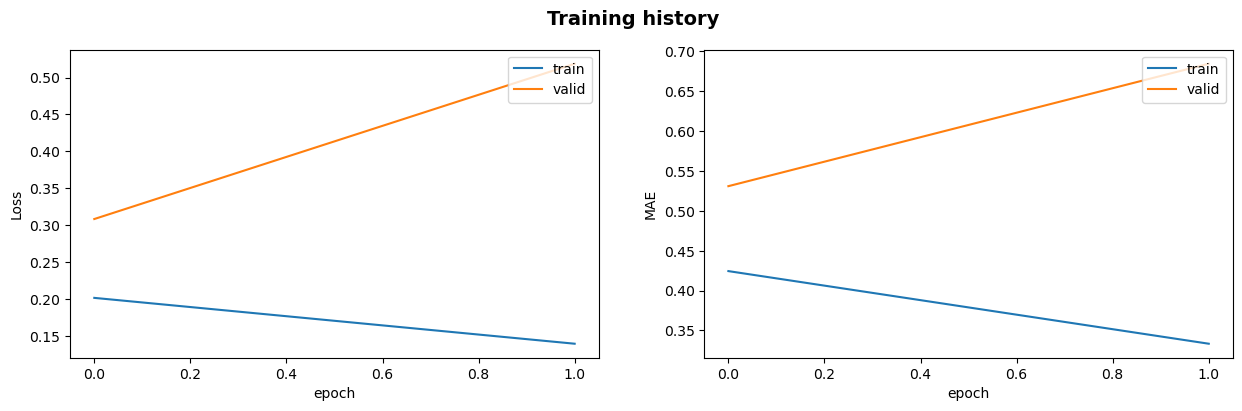

In [22]:
# Visualization
train_hist = history_depth.history

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Training history', fontsize=14, fontweight='bold')

ax1.plot(train_hist['loss'])
ax1.plot(train_hist['val_loss'])
ax1.set(xlabel='epoch', ylabel='Loss')
ax1.legend(['train', 'valid'], loc='upper right')

ax2.plot(train_hist['mae'])
ax2.plot(train_hist['val_mae'])
ax2.set(xlabel='epoch', ylabel='MAE')
ax2.legend(['train', 'valid'], loc='upper right')